# Neural Network From Scratch
- Code taken from https://www.youtube.com/watch?v=w8yWXqWQYmU with slight modification
- Original Code: https://www.kaggle.com/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras

In [79]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_csv("/content/sample_data/mnist_train_small.csv")

data.head()

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into testing set and training sets

data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [58]:
Y_train

array([0, 2, 1, ..., 9, 4, 7])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [71]:
def init_params():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return w1, b1, w2, b2

def relu(z):
    return np.maximum(z, 0)

def deriv_relu(z):
    return z > 0

def softmax(z):
    return (np.exp(z) / sum(np.exp(z)))

def forward_prop(w1, b1, w2, b2, X):
    z1 = w1.dot(X) + b1
    a1 = relu(z1)
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def back_prop(z1, a1, z2, a2, w1, w2, X, Y):
    one_hot_Y = one_hot(Y)
    dz2 = a2 - one_hot_Y
    dw2 = 1 / m * dz2.dot(a1.T)
    db2 = 1 / m * np.sum(dz2)
    dz1 = w2.T.dot(dz2) * deriv_relu(z1)
    dw1 = 1 / m * dz1.dot(X.T)
    db1 = 1 / m * np.sum(dz1)
    return dw1, db1, dw2, db2

def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    return w1, b1, w2, b2

def get_predictions(a2):
    return np.argmax(a2, 0)

def get_accuracy(predictions, Y):
    print(f"{predictions},{Y}")
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    w1, b1, w2, b2 = init_params()
    for i in range(iterations):
        z1, a1, z2, a2 = forward_prop(w1, b1, w2, b2, X)
        dw1, db1, dw2, db2 = back_prop(z1, a1, z2, a2, w1, w2, X, Y)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        if i % 50 == 0:
            print(f"iterations: {i}")
            print(f"accuracy: {get_accuracy(get_predictions(a2), Y)}")
    return w1, b1, w2, b2


In [72]:
w1, b1, w2, b2 = gradient_descent(X_train, Y_train, 1000, 0.1)

iterations: 0
[9 9 9 ... 9 9 3],[0 2 1 ... 9 4 7]
accuracy: 0.13874414442865413
iterations: 50
[0 6 3 ... 9 7 7],[0 2 1 ... 9 4 7]
accuracy: 0.3244381283225433
iterations: 100
[9 4 1 ... 6 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.5070266856150324
iterations: 150
[9 2 1 ... 6 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.6227696194536555
iterations: 200
[0 2 1 ... 9 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.693773356492447
iterations: 250
[0 2 1 ... 9 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.7410390020527396
iterations: 300
[0 2 1 ... 4 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.7703037001947471
iterations: 350
[0 2 1 ... 4 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.791146902468551
iterations: 400
[0 2 1 ... 4 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.8071477446181378
iterations: 450
[0 2 1 ... 4 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.8179377861992736
iterations: 500
[0 2 1 ... 4 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.8275172377493553
iterations: 550
[0 2 1 ... 4 4 7],[0 2 1 ... 9 4 7]
accuracy: 0.8343070687930944
iterations: 600
[0 2 1 ... 4 4 7

In [73]:
def make_predictions(X, w1, b1, w2, b2):
    _, _, _, a2 = forward_prop(w1, b1, w2, b2, X)
    predictions = get_predictions(a2)
    return predictions

def test_prediction(index, w1, b1, w2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], w1, b1, w2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


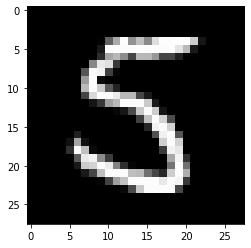

Prediction:  [5]
Label:  3


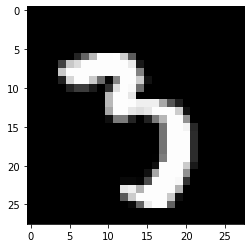

Prediction:  [5]
Label:  5


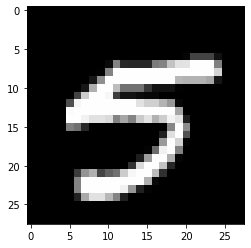

Prediction:  [4]
Label:  4


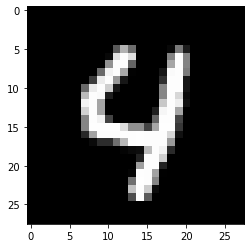

In [80]:
test_prediction(0, w1, b1, w2, b2)
test_prediction(1, w1, b1, w2, b2)
test_prediction(2, w1, b1, w2, b2)
test_prediction(3, w1, b1, w2, b2)

In [81]:
test_set_predictions = make_predictions(X_test, w1, b1, w2, b2)
get_accuracy(test_set_predictions, Y_test)

[1 4 4 9 8 5 0 3 1 3 8 7 4 9 2 9 1 5 6 0 5 1 3 0 0 9 4 8 9 3 5 6 8 8 1 1 4
 6 4 1 2 2 1 1 5 0 6 4 7 6 7 2 0 9 4 1 1 9 7 3 9 2 2 6 5 1 9 7 9 4 5 6 1 0
 8 1 1 1 1 0 0 4 3 3 7 9 1 1 4 3 5 0 4 3 8 6 6 1 4 1 4 4 0 4 9 7 7 1 9 7 7
 2 8 1 3 8 1 8 8 7 1 8 6 9 7 4 3 6 0 0 7 6 2 7 9 9 7 9 3 7 8 9 1 6 7 9 8 1
 0 3 3 6 0 3 1 2 1 4 2 7 1 1 1 6 0 8 8 3 7 7 6 0 9 8 1 0 7 9 1 3 0 2 4 0 1
 1 8 7 6 8 0 3 2 2 7 0 9 5 4 2 1 7 1 0 4 1 9 6 4 6 8 4 8 2 1 4 5 1 6 5 4 0
 6 3 2 3 6 2 6 3 1 1 5 8 6 0 3 0 3 0 5 7 6 5 8 7 3 3 2 7 3 6 9 1 7 0 3 3 3
 3 8 1 6 0 5 6 2 6 8 1 0 7 7 3 9 4 1 9 6 4 0 2 3 1 4 0 9 7 9 6 7 3 6 8 1 9
 6 0 9 5 6 5 5 4 1 7 1 5 7 0 6 5 2 4 8 2 7 7 7 6 7 8 6 7 9 9 7 8 6 6 6 3 4
 8 7 8 1 5 8 1 3 3 6 0 8 7 5 2 4 0 2 4 8 9 9 6 2 3 8 1 8 3 0 6 7 9 9 8 7 0
 3 2 4 2 0 4 7 2 3 1 9 1 1 8 2 8 1 1 6 1 4 8 5 4 1 2 2 6 4 6 2 4 8 1 4 2 4
 9 7 7 8 1 3 4 1 9 3 8 1 1 5 1 3 1 0 6 2 9 1 8 7 4 6 9 1 2 7 4 3 6 6 7 1 5
 3 8 1 8 3 0 2 5 9 6 1 3 1 9 1 5 0 0 0 2 4 3 2 6 7 6 6 3 6 0 1 1 2 7 1 0 0
 7 5 2 7 2 6 7 6 9 5 0 4 

0.894